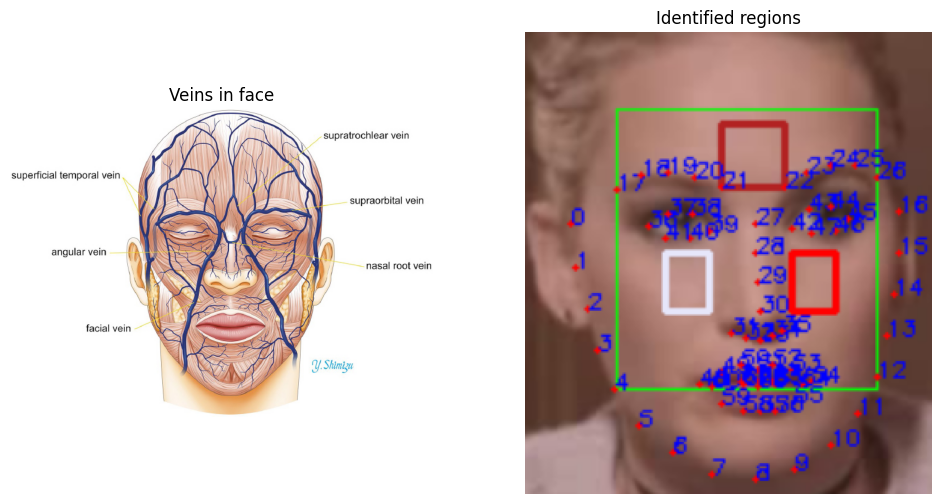

In [14]:
import os
import matplotlib.pyplot as plt
import cv2

# Define image paths
image_path1 = 'images/veins_position.jpg'  # Replace with your first image path
image_path2 = 'images/landmarks.png'  # Replace with your second image path

# Check if the image files exist
if not os.path.isfile(image_path1):
    print("Error: The first image file does not exist.")
if not os.path.isfile(image_path2):
    print("Error: The second image file does not exist.")

# Load images using OpenCV
image1 = cv2.imread(image_path1)
image2 = cv2.imread(image_path2)

# Check if the images are loaded successfully
if image1 is None or image2 is None:
    print("Error: Could not load one or both images.")
else:
    # Convert the images from BGR to RGB format
    image1_rgb = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
    image2_rgb = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)

    # Create a figure with 1 row and 2 columns of subplots
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Display the first image in the first subplot
    axes[0].imshow(image1_rgb)
    axes[0].axis('off')  # Hide the axes
    axes[0].set_title('Veins in face')

    # Display the second image in the second subplot
    axes[1].imshow(image2_rgb)
    axes[1].axis('off')  # Hide the axes
    axes[1].set_title('Identified regions')

    # Display the figure
    plt.show()


In [3]:
import cv2
import dlib

# Load face detector and facial landmark predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("dlib_files/shape_predictor_68_face_landmarks.dat")

# Open video file
video_path= 'videos/real/jenny.mp4'
cap = cv2.VideoCapture(video_path)

# Process each frame in the video
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Convert frame to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Detect faces in the frame
    faces = detector(gray)
    
    if(len(faces) > 1):
        break

    # Process each detected face
    for face in faces:
        # Detect facial landmarks
        landmarks = predictor(gray, face)
        
        # Identify forehead region based on landmarks
        forehead_r1=[0,0,0,0] #x1,x2,y1,y2
        
        forehead_r1[0] = landmarks.part(21).x # Left eyebrow-x
        forehead_r1[1] = landmarks.part(22).x  # Right eyebrow-x
        forehead_r1[2] = landmarks.part(21).y # Left eyebrow-y
        forehead_r1[3] = landmarks.part(22).y # Right eyebrow-y
        
        forehead_r1_height=int((forehead_r1[1] - forehead_r1[0]))
        
        

        # Identify left cheek region-1 based on landmarks
        leftc_r1=[0,0,0,0] #x1,x2,y1,y2
        
        leftc_r1[0]=landmarks.part(41).x
        leftc_r1[1]=landmarks.part(39).x
        leftc_r1[2]=landmarks.part(28).y
        leftc_r1[3]=landmarks.part(30).y

        # Identify right cheek region-1 based on landmarks
        rightc_r1=[0,0,0,0] #x1,x2,y1,y2
        
        rightc_r1[0]=landmarks.part(42).x
        rightc_r1[1]=landmarks.part(46).x
        rightc_r1[2]=landmarks.part(28).y
        rightc_r1[3]=landmarks.part(30).y

        # Identify right cheek region-1 based on landmarks
        fullf=[0,0,0,0] #x1,x2,y1,y2
        
        fullf[0]=landmarks.part(17).x
        fullf[1]=landmarks.part(26).x
        fullf[2]=landmarks.part(19).y - forehead_r1_height
        fullf[3]=landmarks.part(4).y


        
        
        # Draw rectangle with increased breadth
        cv2.rectangle(frame, (forehead_r1[0], forehead_r1[2]-forehead_r1_height), (forehead_r1[1], forehead_r1[3]), (34,34,178), 2)
        cv2.rectangle(frame, (leftc_r1[0], leftc_r1[2]), (leftc_r1[1], leftc_r1[3]), (250, 230, 230), 2)
        cv2.rectangle(frame, (rightc_r1[0], rightc_r1[2]), (rightc_r1[1], rightc_r1[3]), (0, 0, 255), 2)
        cv2.rectangle(frame, (fullf[0], fullf[2]), (fullf[1], fullf[3]), (0, 255, 0), 1)
        # Draw facial landmarks with numbers
        for i in range(0, 68):
            x = landmarks.part(i).x
            y = landmarks.part(i).y
            cv2.circle(frame, (x, y), 1, (0, 0, 255), -1)
            cv2.putText(frame, str(i), (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (255, 0, 0), 1)

    # Display frame with highlighted forehead region and facial landmarks
    cv2.imshow('Face Regions Detection with Landmarks', frame)

    # Exit if 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release video capture and close windows
cap.release()
cv2.destroyAllWindows()

In [ ]:
import cv2
import numpy as np
from scipy.signal import butter, filtfilt
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq

# Window sizes for extracting heart rate
windowSizes = [40]
# Low and high cutoff frequencies
lowcut = 0.75  # Low cut frequency for bandpass filter
highcut = 2.25  # High cut frequency for bandpass filter

# Sampling rate
fs = 2 * highcut

def normalize_video(video, window_size):
    video = video.astype(np.float32)
    normalized_video = np.zeros_like(video)
    for frame_idx in range(video.shape[0]):
        # Get a window of frames around the current frame
        window_start = max(0, frame_idx - window_size // 2)
        window_end = min(video.shape[0], frame_idx + window_size // 2 + 1)
        window = video[window_start:window_end]

        # Calculate average color for each channel across the window
        average_color = np.mean(window, axis=0)

        # Normalize each channel of the current frame
        normalized_video[frame_idx] = video[frame_idx] / average_color

    return normalized_video

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs  # Nyquist frequency
    lowcut_norm = lowcut / nyquist 
    highcut_norm = highcut / nyquist
    # print(lowcut,highcut,lowcut_norm,highcut_norm)
    b, a = butter(order, [lowcut_norm, highcut_norm-0.1], btype='band')
    return b, a

def apply_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order)
    y = filtfilt(b, a, data, axis=0)
    return y

def bandpass_filter(frames, lowcut, highcut, fs, order=5):
    filtered_images = np.empty_like(frames)
    for i, frame in enumerate(frames):
        filtered_images[i] = apply_bandpass_filter(frame, lowcut, highcut, fs, order)
    return filtered_images

def hearrate_detected(signal, fps):
    # Collapse 3D signal array to 1D time series by averaging over spatial dimensions
    time_series = np.mean(signal, axis=(1, 2))

    # Apply FFT
    N = len(time_series)
    yf = fft(time_series)
    xf = fftfreq(N, 1 / fps)[:N // 2]

    # Find the dominant frequency in the expected heart rate range
    heart_rate_range = (lowcut, highcut)
    idx_range = np.where((xf >= heart_rate_range[0]) & (xf <= heart_rate_range[1]))
    dominant_freq = xf[idx_range][np.argmax(np.abs(yf[idx_range]))]

    # Convert frequency to beats per minute (BPM)
    bpm = dominant_freq * 60

    return bpm

# Read video from file
video_path = "videos/fake/vid.mp4"
cap = cv2.VideoCapture(video_path)

if not cap.isOpened():
    print("Error opening video file")
    exit()

# Load the Haar cascade for face detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Get video properties
fps = int(cap.get(cv2.CAP_PROP_FPS))

# Allocate memory for storing video frames
left_cheek_frames = []
right_cheek_frames = []
forehead_frames = []
full_face_frames = []

isWAndHObtained = False
cheek_w, cheek_h = 0, 0
forehead_h, forehead_w = 0, 0
face_h, face_w = 0, 0

# Read frames from video and detect face region
while True:
    ret, frame = cap.read()
    if not ret:
        break
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    
    if len(faces) > 0:
        # Assume the first detected face is the region of interest
        x, y, w, h = faces[0]

        # Define regions for left cheek, right cheek, and forehead
        if not isWAndHObtained:
            cheek_w = w // 4
            cheek_h = h // 4
            forehead_h = h // 5
            forehead_w = w // 2
            face_h, face_w = h, w
            isWAndHObtained = True

        left_cheek = frame[y + h // 2:y + h // 2 + cheek_h, x:x + cheek_w]
        right_cheek = frame[y + h // 2:y + h // 2 + cheek_h, x + w - cheek_w:x + w]
        forehead = frame[y:y + forehead_h, x + w // 4:x + w // 4 + forehead_w]
        full_face = frame[y:y + face_h, x:x + face_w]

        left_cheek_frames.append(left_cheek)
        right_cheek_frames.append(right_cheek)
        forehead_frames.append(forehead)
        full_face_frames.append(full_face)

cap.release()
cv2.destroyAllWindows()

# Function to process each region and estimate heart rate
def process_region(region_frames, region_name):
    # Convert frames list to a numpy array
    video = np.array(region_frames)

    # Normalize the video
    for windowSize in windowSizes:
        normalized_with_windowSize = normalize_video(video.copy(), windowSize)

        Rn = normalized_with_windowSize[:, :, :, 0]
        Gn = normalized_with_windowSize[:, :, :, 1]
        Bn = normalized_with_windowSize[:, :, :, 2]

        Xs = 3 * Rn - 2 * Gn
        Ys = 1.5 * Rn + Gn - 1.5 * Bn

        # Apply bandpass filter
        Rf = bandpass_filter(Rn, lowcut, highcut, fs)
        Gf = bandpass_filter(Gn, lowcut, highcut, fs)
        Bf = bandpass_filter(Bn, lowcut, highcut, fs)
        Xf = bandpass_filter(Xs, lowcut, highcut, fs)
        Yf = bandpass_filter(Ys, lowcut, highcut, fs)

        alpha = np.std(Xf) / np.std(Yf)

        signal = np.empty_like(Rf)
        for i, frame in enumerate(signal):
            signal[i] = 3 * (1 - (alpha / 2)) * Rf[i] - 2 * (1 + (alpha / 2)) * Gf[i] + ((3 * alpha) / 2) * Bf[i]
        
        bpm = hearrate_detected(signal, fps)
        print(f"Estimated Heart Rate from {region_name}: {bpm} BPM")
        
        # Plot the signal
        time_series = np.mean(signal, axis=(1, 2))
        plt.plot(time_series, label=f'{region_name} Pulse Signal')
        plt.title(f'{region_name} Pulse Signal over Time')
        plt.xlabel('Time')
        plt.ylabel('Intensity')
        plt.legend()
        plt.text(0.05, 0.95, f'Estimated Heart Rate: {bpm:.2f} BPM', horizontalalignment='left', verticalalignment='top', transform=plt.gca().transAxes, fontsize=12, bbox=dict(facecolor='white', alpha=0.8))
        plt.savefig(f'plots/{region_name}_pulse_signal.png')
        plt.clf()
        
        return bpm, signal

# Process each region and get heart rate
left_cheek_bpm, left_cheek_signal = process_region(left_cheek_frames, 'Left Cheek')
right_cheek_bpm, right_cheek_signal = process_region(right_cheek_frames, 'Right Cheek')
forehead_bpm, forehead_signal = process_region(forehead_frames, 'Forehead')
full_face_bpm, full_face_signal = process_region(full_face_frames, 'Full Face')

# Superimpose all plots in a single plot
plt.figure(figsize=(10, 6))
plt.plot(np.mean(left_cheek_signal, axis=(1, 2)), label='Left Cheek Pulse Signal')
plt.plot(np.mean(right_cheek_signal, axis=(1, 2)), label='Right Cheek Pulse Signal')
plt.plot(np.mean(forehead_signal, axis=(1, 2)), label='Forehead Pulse Signal')
plt.plot(np.mean(full_face_signal, axis=(1, 2)), label='Full Face Pulse Signal')
plt.title('Superimposed Pulse Signals')
plt.xlabel('Time')
plt.ylabel('Intensity')
plt.legend()
plt.savefig('plots/superimposed_pulse_signals.png')